## Introduce
word2vec的引入，由于one-hot编码无法准确表达不同词之间的相似度，因此为了解决这个问题，提出了Word2Vec，它将每个词表示成一个定长的向量，并通过在语料上预训练是的这些向量能较好的表达不同词之间的相似和类比关系，以引入一定的语义信息。基于两种概率模型的假设，可以定义两种word2vec模型。

1. Skip-Gram跳字模型：假设背景词由中心词生成，即建模$P(w_0|w_c)$，其中$w_c$为中心词，$w_0$为任一背景词。 

![skip-gram](imgs/skip-gram.png)

2. CBOW (continuous bag-of-word)连续词袋模型：假设中心词由背景词生成，即建模 $P(w_c\mid \mathcal{W}_o)$，其中 $\mathcal{W}_o$ 为背景词的集合。

![Image Name](imgs/cbow.png)


In [67]:
import collections
import math
import random
import sys
import time
import os
import numpy as np
import torch
from torch import nn
import torch.utils.data as Data
import jieba
sys.path.append('.')
from utils import files_processing
from gensim.models import word2vec
import multiprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# 设置matplotlib正常显示中文和负号
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号

## word2vec基本原理探究
使用经典的PTB语料进行训练。[PTB (Penn Tree Bank)](https://catalog.ldc.upenn.edu/LDC99T42) 是一个常用的小型语料库，它采样自《华尔街日报》的文章，包括训练集、验证集和测试集。我们将在PTB训练集上训练词嵌入模型。

### 加载数据集

In [7]:
with open('dataset/ptb/ptb.train.txt') as f:
    lines = f.readlines()
    raw_dataset = [st.split() for st in lines]

print('# sentences: %d' % len(raw_dataset))

# 查看前3个句子
for st in raw_dataset[:3]:
    print('# tokens', len(st), st[:5])

# sentences: 42068
# tokens 24 ['aer', 'banknote', 'berlitz', 'calloway', 'centrust']
# tokens 15 ['pierre', '<unk>', 'N', 'years', 'old']
# tokens 11 ['mr.', '<unk>', 'is', 'chairman', 'of']


### 建立词语索引

In [8]:
counter = collections.Counter([tk for st in raw_dataset for tk in st]) # 依次遍历所有数据集、句子和词语
counter = dict(filter(lambda x: x[1] >= 5, counter.items()))  # 保留在数据集中至少出现5词的词 词:词频

idx_to_token = [tk for tk, _ in counter.items()]
token_to_idx = {tk : idx for idx, tk in enumerate(idx_to_token)}

dataset = [[token_to_idx[tk] for tk in st if tk in token_to_idx] for st in raw_dataset]  # 将数据中的词都转化为index

num_tokens = sum([len(st) for st in dataset])
print('# tokens: %d' % num_tokens)

# tokens: 887100


### 二次采样
文本数据中一般会出现一些高频词，如英文中的‘the’,'a'和‘in’。通常来说，在一个背景窗口中，一个词（如‘chip’）和低频词（如‘microprocessor’）同时出现比和较高频词（如‘the’）同时出现对训练词嵌入模型更加有益。因此，训练词嵌入模型时可以对词进行二次采样。具体来说，数据集中每个单词$w_i$将有一定概率被丢弃，该被丢弃概率为
$$P(w_i) = max(1 - \sqrt{\frac{t}{f(w_i)}}, 0)$$
其中$f(w_i)$是数据集中词$w_i$的个数与总词数之比，常数$t$是一个超参数（实验中设为$10^{-4}$）。可见，只有当$f(w_i) > t$时，才有可能在二次采样中丢弃词$w_i$，并且越高频词被丢弃的概率越大。

In [9]:
def discard(idx, t=1e-4):
    """
    @params:
        idx: 单词的下标
    @return: True/False 表示是否丢弃该单词
    """
    return random.uniform(0, 1) < 1 - math.sqrt(t / counter[idx_to_token[idx]] * num_tokens)

subsampled_dataset = [[tk for tk in st if not discard(tk)] for st in dataset]
print('# tokens: %d' % sum([len(st) for st in subsampled_dataset]))

def compare_counts(token):
    return '# %s: before=%d, after=%d' % (
        token, 
        sum([st.count(token_to_idx[token]) for st in dataset]),
        sum([st.count(token_to_idx[token]) for st in subsampled_dataset])
    )

print(compare_counts('the'))
print(compare_counts('join'))

# tokens: 375983
# the: before=50770, after=2103
# join: before=45, after=45


### 提取中心词和背景词

In [10]:
def get_centers_and_contexts(dataset, max_window_size):
    """
    @params:
        dataset: 数据集为句子的集合，每个句子则为单词的集合，此时单词已经被转换相应的数字下标
        max_window_size: 背景词的窗口大小的最大值
    @return 
        all_negatives: 中心词的集合
        contexts: 背景词窗口的集合，与中心词对应，每个背景词窗为背景词的集合
    """
    centers, contexts = [], []
    for st in dataset:
        if len(st) < 2: # 每个句子至少要有2个词才能组成一对‘中心词-背景词’
            continue
        centers += st
        for center_i in range(len(st)):
            window_size = random.randint(1, max_window_size)  # 随机选取背景词窗大小
            indices = list(range(max(0, center_i - window_size), min(len(st), center_i + 1 + window_size)))
            indices.remove(center_i)  # 将中心词排除在背景词之外
            contexts.append([st[idx] for idx in indices])
    return centers, contexts

all_centers, all_contexts = get_centers_and_contexts(subsampled_dataset, 5)
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)

for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [2, 4]
center 4 has contexts [3, 5]
center 5 has contexts [4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


### Skip-Gram跳字模型

在跳字模型中，每个词被表示为两个$d$维向量，用来计算条件概率。假设这个词在词典中索引为$i$，当它为中心词时向量表示为$v_i \in R^d$，而为背景词时向量表示为$u_i \in R^d$。设中心词$w_c$在词典中索引为$c$，背景词$w_o$在词典中索引为$o$，我们假设给定中心词生成背景词的条件概率满足下式：
$$P(w_o|w_c)=\frac{exp(u_o^T v_c)}{\sum_{i \in V}exp(u_i^T v_c)}$$
其中$V$表示词典。

#### pytorch预置的embedding层

In [11]:
embed = nn.Embedding(num_embeddings=10, embedding_dim=4)  # num_embeddings=10，可以表示单词总数目，embedding_dim，可以表示为词嵌入维度
print(embed.weight.shape)

x = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.long)  # 2x3

print(embed(x).shape)

torch.Size([10, 4])
torch.Size([2, 3, 4])


#### pytorch预置的批量乘法

In [12]:
X = torch.ones((2, 1, 4))  # 第一维为channal
Y = torch.ones((2, 4, 6))
print(torch.bmm(X, Y).shape)

torch.Size([2, 1, 6])


### skip-gram前向计算

In [13]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    """
    @params:
        center: 中心词，形状为（n,1）的张量
        contexts_and_negatives: 背景词和噪音词下标，形状为（n,m）的整数张量
        embed_v: 中心词embedding层
        embed_u: 背景词embedding层
    @return
        pred: 中心词和背景词的内积，之后用于计算概率P(w_o|w_c)
    """
    v = embed_v(center)    # n, 1, d
    u = embed_u(contexts_and_negatives)  # n m d
    pred = torch.bmm(v, u.permute(0, 2, 1)) # nx1xd nxdxm -> nx1xm
    return pred

### 负采样近似
由于softmax运算考虑了背景词可能是词典中$V$的任一词，对应于含几十万或上百万词的较大词典，可能导致开销过大。采用负采样的方式可以近似条件概率$P(w_o|w_c)=\frac{exp(u_o^T v_c)}{\sum_{i \in V} exp(u_i^T v_c)}$。

**负采样解释**

给定一个文本序列$w_1, w_2, \cdots, w_{c-m}, \cdots, w_c, \cdots, w_{c+m}, \cdots, w_T$，某个中心词$w_c$窗口大小为$m$。$\{{w_c, w_{c-m}\}, \cdots, \{{w_c, w_{c+m}\}}}$称为正样本，我们按照一定的概率分布$P(\bar{w})$从词典中抽取$K$个负样本$\bar{w}_1, \bar{w}_2, \cdots, \bar{w}_K$，那么$\{{w_c, \bar{w}_K}\}(k=1,\cdots, K)$称为负样本。那么给定中心词$w_c$，预测$w_j(j\in (c-m, c+m))$由以下事件构成：
- $w_c$和$w_j$共同出现
- $w_c$没有$\bar{w}_1$共同出现
- $\cdots$
- $w_c$没有$\bar{w}_K$共同出现

在一个文本序列中，设$P(D=1|w_j, w_c)$为中心词$w_c$和词$w_j$在当前窗口中同时出现的概率，$w_j$是需要预测的词，可能是当前窗口中中心词的上下文，也有可能不是当前窗口中的上下文词。$P(D=0|w_j, w_c)$为中心词$w_c$和词$w_j$在没有当前窗口中同时出现的概率。以上事件的联合概率分布为：
$$P(D=1|w_j, w_c)\prod_{k=1}^K P(D=0|\bar{w}_k, w_c)$$
其中
$$P(D=1|w_j, w_c) = 1 - P(D=0|w_j, w_c)$$
取对数进一步可得
$$log \ P(D=1|w_j, w_c) + \sum_{k=1}^K \ log(1-P(D=1|\bar{w}_k, w_c))$$

其中中心词和负样本在同一窗口概率$u_j$表示输出词的词向量表示，$v_c$表示输入词（中心词）的词向量表示，由于结果只有两种情况（共现和非共现），则可以使用sigmoid函数来进行表示两个词共现的概率。

![](imgs\sigmoid.png)

即原始的softmax预测概率转化为
$log \frac{1}{1+exp(-u_j^Tv_c)} + \sum_{k=1}^K log\frac{1}{1+exp(u_k^Tv_c)}$
由上可知，上式为二分类的交叉熵函数，这样的话可以将softmax函数中的$O(W)$复杂度降低为$O(K)$。其中
$$P(w_j|w_c)=P(D=1|w_j,w_c)=\sigma(u_j^Tv_c)=\frac{1}{1+exp(-u_j^Tv_c)}$$

其中根据Word2vec论文建议$P(w)$设为$w$词频与总词频之比的0.75次方。

In [15]:
def get_negatives(all_contexts, sampling_weights, K):
    """
    @params:
        all_contexts: [[w_o1, w_o2, ...], [...], ...]
        sampling_weights: 每个单词的噪声词采样概率
        K：随机采样个数
    @return 
        all_negatives: [[w_n1, w_n2, ...], [...], ...]
    """
    all_negatives, neg_candidates, i = [], [], 0
    population = list(range(len(sampling_weights)))
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            if i == len(neg_candidates):
                i, neg_candidates = 0, random.choices(population, sampling_weights, k=int(1e5))
            neg, i = neg_candidates[i], i + 1
            if neg not in set(contexts):
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

sampling_weights = [counter[w] ** 0.75 for w in idx_to_token]
all_negatives = get_negatives(all_contexts, sampling_weights, 5)

In [21]:
len(all_negatives), len(all_negatives[2]), len(all_contexts), all_contexts[2], len(all_centers), all_centers[0]

(375039, 35, 375039, [0, 1, 6, 8, 10, 11, 12], 375039, 0)

### 批量读取数据

In [20]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives
        
    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index], self.negatives[index])

    def __len__(self):
        return len(self.centers)
    
def batchify(data):
    """
    用作DataLoader的参数collate_fn
    @params:
        data: 长为batch_size的列表，列表中的每个元素都是__getitem__得到的结果
    @outputs:
        batch: 批量化后得到 (centers, contexts_negatives, masks, labels) 元组
            centers: 中心词下标，形状为 (n, 1) 的整数张量
            contexts_negatives: 背景词和噪声词的下标，形状为 (n, m) 的整数张量
            masks: 与补齐相对应的掩码，形状为 (n, m) 的0/1整数张量
            labels: 指示中心词的标签，形状为 (n, m) 的0/1整数张量
    """
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)] # 使用掩码变量mask来避免填充项对损失函数计算的影响
        labels += [[1] * len(context) + [0] * (max_len - len(context))]  # 负样本除了采样的还有就是，使用0进行填充的
        batch = (torch.tensor(centers).view(-1, 1), torch.tensor(contexts_negatives),
            torch.tensor(masks), torch.tensor(labels))
    return batch

batch_size = 512
num_workers = 0 if sys.platform.startswith('win32') else 4

dataset = MyDataset(all_centers, all_contexts, all_negatives)
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True,
                            collate_fn=batchify, 
                            num_workers=num_workers)
for batch in data_iter:
    for name, data in zip(['centers', 'contexts_negatives', 'masks',
                           'labels'], batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


### 训练模型
**损失函数**

$$
\sum_{t=1}^T\sum_{-m\le j\le m,j\ne 0} [-\log P(D=1\mid w^{(t)},w^{(t+j)})-\sum_{k=1,w_k\sim P(w)^K}\log P(D=0\mid w^{(t)},w_k)]
$$


根据这个损失函数的定义，直接使用二元交叉熵损失函数进行计算：

In [22]:
class SigmoidBinaryCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(SigmoidBinaryCrossEntropyLoss, self).__init__()
    def forward(self, inputs, targets, mask=None):
        """
        @params:
            inputs: 经过sigmoid层后为预测D=1的概率
            targets: 0/1向量，1代表背景词，0代表噪音词
        @return:
            res: 平均到每个label的loss
        """
        inputs, targets, mask = inputs.float(), targets.float(), mask.float()
        res = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction="none", weight=mask)
        res = res.sum(dim=1) / mask.float().sum(dim=1)
        return res

loss = SigmoidBinaryCrossEntropyLoss()

pred = torch.tensor([[1.5, 0.3, -1, 2], [1.1, -0.6, 2.2, 0.4]])
label = torch.tensor([[1, 0, 0, 0], [1, 1, 0, 0]]) # 标签变量label中的1和0分别代表背景词和噪声词
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 1, 0]])  # 掩码变量
print(loss(pred, label, mask))

def sigmd(x):
    return - math.log(1 / (1 + math.exp(-x)))
print('%.4f' % ((sigmd(1.5) + sigmd(-0.3) + sigmd(1) + sigmd(-2)) / 4)) # 注意1-sigmoid(x) = sigmoid(-x)
print('%.4f' % ((sigmd(1.1) + sigmd(-0.6) + sigmd(-2.2)) / 3))

tensor([0.8740, 1.2100])
0.8740
1.2100


### 初始化模型

In [26]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(idx_to_token), embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(idx_to_token), embedding_dim=embed_size))

### 训练模型

In [ ]:
def train(net, lr, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("train on", device)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # 优化器
    for epoch in range(num_epochs):
        start, l_sum, n = time.time(), 0.0, 0
        for batch in data_iter:
            center, context_negative, mask, label = [d.to(device) for d in batch]
            
            pred = skip_gram(center, context_negative, net[0], net[1])
            
            l = loss(pred.view(label.shape), label, mask).mean() # 一个batch的平均loss
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            l_sum += l.cpu().item()
            n += 1
        print('epoch %d, loss %.2f, time %.2fs'
              % (epoch + 1, l_sum / n, time.time() - start))

train(net, 0.01, 5)

### 测试模型

In [ ]:
def get_similar_tokens(query_token, k, embed):
    '''
    @params:
        query_token: 给定的词语
        k: 近义词的个数
        embed: 预训练词向量
    '''
    W = embed.weight.data
    x = W[token_to_idx[query_token]]
    # 添加的1e-9是为了数值稳定性
    cos = torch.matmul(W, x) / (torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9).sqrt()  # 余弦相似度
    _, topk = torch.topk(cos, k=k+1)
    topk = topk.cpu().numpy()
    for i in topk[1:]:  # 除去输入词
        print('cosine sim=%.3f: %s' % (cos[i], (idx_to_token[i])))
        
get_similar_tokens('chip', 3, net[0])  # v 中心词

## 三国演义分析

In [9]:
source_folder = 'dataset/three_kingdoms/source/'
segment_folder = 'dataset/three_kingdoms/segment/'
stopwords_file = 'dataset/three_kingdoms/stopwords.txt'
model_file = 'dataset/three_kingdoms/models/'

In [3]:
def segment_lines(file_list,segment_out_dir,stopwords=[]):
    for i,file in enumerate(file_list):
        segment_out_name=os.path.join(segment_out_dir,'segment_{}.txt'.format(i))
        with open(file, 'rb') as f:
            document = f.read()
            document_cut = jieba.cut(document)
            sentence_segment=[]
            for word in document_cut:
                if word not in stopwords:
                    sentence_segment.append(word)
            result = ' '.join(sentence_segment)
            result = result.encode('utf-8')
            with open(segment_out_name, 'wb') as f2:
                f2.write(result)

# 对source中的txt文件进行分词，输出到segment目录中
file_list=files_processing.get_files_list(source_folder, postfix='*.txt')
with open(stopwords_file, 'rb') as f:
    stopwords = [word.strip() for word in f.readlines()]
segment_lines(file_list, segment_folder, stopwords)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\thinksee\AppData\Local\Temp\jieba.cache
Loading model cost 2.076 seconds.
Prefix dict has been built successfully.


In [53]:
# 如果目录中有多个文件，可以使用PathLineSentences
sentences = word2vec.PathLineSentences(segment_folder)
# 设置模型参数，进行训练
model = word2vec.Word2Vec(sentences, size=256, window=7, min_count=5, workers=multiprocessing.cpu_count())
# 保存模型
model.save(model_file + 'word2Vec.model')

In [54]:
key = '曹操'

In [55]:
key_similar = model.wv.most_similar(positive=[key])

In [60]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 256), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 128 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

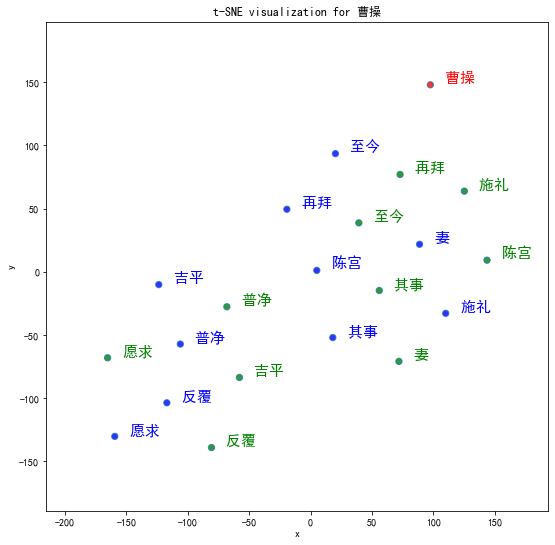

In [61]:
tsnescatterplot(model, key , [val for val, sim in key_similar])

In [62]:
model.wv.vectors.shape

(7576, 256)

In [63]:
diff = model.wv.vectors[model.wv.vocab['曹操'].index] + model.wv.vectors[model.wv.vocab['刘备'].index] - model.wv.vectors[model.wv.vocab['张飞'].index]

In [64]:
diff

array([ 0.49460888,  0.7077824 , -0.20553754,  0.01666102, -0.7367102 ,
       -1.6063187 ,  0.06006914, -0.6465473 , -0.25196746, -0.2383393 ,
        0.26354122, -0.2547242 ,  0.03313252,  0.44526428,  0.0052729 ,
        0.41189876, -0.3148582 ,  0.07270121,  0.25936133, -0.4799904 ,
       -0.16791664, -0.11199747, -0.18375838, -0.02909552,  0.6317071 ,
       -0.00445095, -0.55216163,  0.15906657, -0.22643057,  0.17075293,
       -0.5421487 , -0.14504106,  0.81612587, -0.8833269 , -0.18587877,
        0.9971214 , -0.11514871,  0.84644663,  0.98394686,  0.33239824,
       -0.1598773 , -0.6571071 , -0.28300947,  0.6336794 , -0.39398032,
       -0.22683221,  0.6803193 , -0.41576332,  0.4157681 ,  0.6830084 ,
        0.57932675, -0.02631037,  0.43965936, -0.39018217, -0.505124  ,
       -0.685711  , -0.11210967, -0.63473225,  0.85132617,  0.28266877,
       -0.16004938, -0.674787  ,  0.32271555,  0.34791705,  0.13810757,
        0.24735314, -0.22097842,  0.31083485,  0.1323286 ,  1.09

In [68]:
def cos_sim(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    :param vector_a: 向量 a 
    :param vector_b: 向量 b
    :return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

In [78]:
idx = [(i, cos_sim(diff, other)) for i, other in enumerate(model.wv.vectors)]
idx.sort(key=lambda x: x[1], reverse=True)

In [95]:
list(model.wv.vocab.keys())[idx[0][0]]

'结束'

- 当计算不同元素/单词之间相加减时，基本思路是使用词向量直接做运算，然后利用余弦相似度找出最相近的单词。
- 需要注意的是，每次模型的输出结果不同的原因，模型中使用了采样技术或者使用了一定的概率技术进行了样本的处理